In [46]:
import pickle
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
import util
import importlib
import time
importlib.reload(util)
start_time_4 = time.time()

# Model and Feature Loading Phase

In [47]:


start_time_1 = time.time()

MODEL_PATH = 'config_v256d03.h5'
SCALER_PATH = 'config_v256d03_scalers.pkl'

with open(SCALER_PATH, 'rb') as f:
    config = pickle.load(f)
model = load_model(MODEL_PATH, compile=False)


# Step 1: Compute snapshot features resotring to snapshot_features_df and save rolling window to be stock_22753_df
snapshot_features_df = pd.read_csv("snapshot_features_df.csv")

rolling_features_df = pd.read_csv("stock_22753_df.csv")

# Preview
print("Rolling features:", rolling_features_df.shape)
display(rolling_features_df.head())

print("Rolling features:", snapshot_features_df.shape)
display(snapshot_features_df.head())


end_time_1 = time.time()


Rolling features: (746066, 25)


,stock_id,time_id,start_time,wap_mean,wap_std,wap_max,wap_min,spread_pct_mean,spread_pct_std,spread_pct_max,...,depth_ratio_mean,depth_ratio_std,depth_ratio_max,depth_ratio_min,log_return_mean,log_return_std,log_return_max,log_return_min,realized_volatility,datetime
0,22753.0,6.0,1800.0,126.417330,0.073325,126.578742,126.305623,0.000149,0.000046,0.000237,...,10.330577,37.813430,299.9997,0.006536,-0.000006,0.000084,0.00044,-0.000264,0.000185,NaN
1,22753.0,6.0,1802.0,126.413860,0.071664,126.578742,126.305623,0.000149,0.000045,0.000237,...,10.195280,37.800391,299.9997,0.006536,-0.000005,0.000084,0.00044,-0.000264,0.000129,NaN
2,22753.0,6.0,1805.0,126.410701,0.070046,126.578742,126.305623,0.000151,0.000046,0.000237,...,10.656852,38.531688,299.9997,0.006536,-0.000005,0.000083,0.00044,-0.000264,0.000329,NaN
3,22753.0,6.0,1807.0,126.407810,0.069242,126.578742,126.305623,0.000151,0.000045,0.000237,...,10.453838,38.506543,299.9997,0.006536,-0.000005,0.000082,0.00044,-0.000264,0.000446,NaN
4,22753.0,6.0,1810.0,126.405019,0.067859,126.578742,126.305623,0.000152,0.000046,0.000237,...,10.422791,38.512527,299.9997,0.006536,-0.000004,0.000084,0.00044,-0.000264,0.000438,NaN


Rolling features: (3730669, 18)


,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,mid_price,wap,bid_ask_spread,spread_pct,imbalance,depth_ratio,log_return
0,22753,6,1800.0,126.57,126.58,126.56,126.59,1,100,26,118,126.575,126.570098,0.01,0.000079,-0.980198,0.010000,0.000000
1,22753,6,1800.0,126.57,126.58,126.56,126.59,1,100,26,118,126.575,126.570098,0.01,0.000079,-0.980198,0.010000,0.000000
2,22753,6,1801.0,126.54,126.56,126.53,126.57,100,4,29,226,126.550,126.559230,0.02,0.000158,0.923077,24.999994,-0.000086
3,22753,6,1801.0,126.54,126.56,126.53,126.57,100,4,29,226,126.550,126.559230,0.02,0.000158,0.923077,24.999994,0.000000
4,22753,6,1802.0,126.56,126.57,126.55,126.58,100,104,110,108,126.565,126.564901,0.01,0.000079,-0.019608,0.961538,0.000045


# Feature Engineering

In [48]:

start_time_2 = time.time()

seq_df = util.generate_tick_sequences(
    snapshot_features_df,
    feature_cols=["wap","spread_pct","imbalance","depth_ratio","log_return"],
    window=config.get('window', util.WINDOW_SIZE),
    horizon=config.get('horizon', util.FORECAST_HORIZON),
    step=config.get('step', util.STEP)
)

subset = seq_df.iloc[-len(seq_df) // 5:]  # rencetly 20%
X = np.stack(subset['X'].values)         # shape: (n_samples, window, n_features)
y_true = subset['y'].values              # shape: (n_samples,)

n_samples, window, n_feats = X.shape
X_scaled = config['x_scaler'].transform(X.reshape(-1, n_feats)).reshape(n_samples, window, n_feats)
y_scaled = config['y_scaler'].transform(y_true.reshape(-1, 1)).flatten()

end_time_2 = time.time()

# model test

In [49]:
start_time_3 = time.time()
y_pred_scaled = model.predict(X_scaled)
y_pred = config['y_scaler'].inverse_transform(y_pred_scaled).flatten()

results_df = pd.DataFrame({
    'time_id': subset['time_id'].values,
    'start_time':subset['start_time'].values,
    'y_true': subset['y'].values,
    'y_pred': y_pred
})

mse = mean_squared_error(y_true, y_pred)
qlike = np.mean((y_true - y_pred) ** 2 / (y_true ** 2))

print(f"Performance:")
print(f"  • MSE   = {mse:.6e}")
print(f"  • QLIKE = {qlike:.6e}")


end_time_3 = time.time()


4176/4176 ━━━━━━━━━━━━━━━━━━━━ 279s 66ms/step
Performance:
  • MSE   = 5.298305e-08
  • QLIKE = 2.746045e+01


# visualization

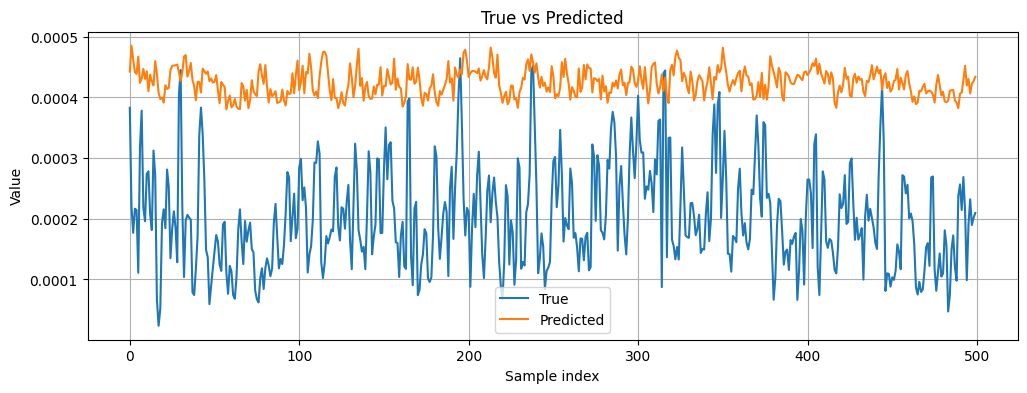

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(y_true[:500], label="True")
plt.plot(y_pred[:500], label="Predicted")
plt.legend()
plt.title("True vs Predicted")
plt.xlabel("Sample index")
plt.ylabel("Value")
plt.grid(True)
plt.show()


Mean Residual: -0.000204
Std of Residual: 0.000106
Min Residual: -0.000504
Max Residual: 0.001742


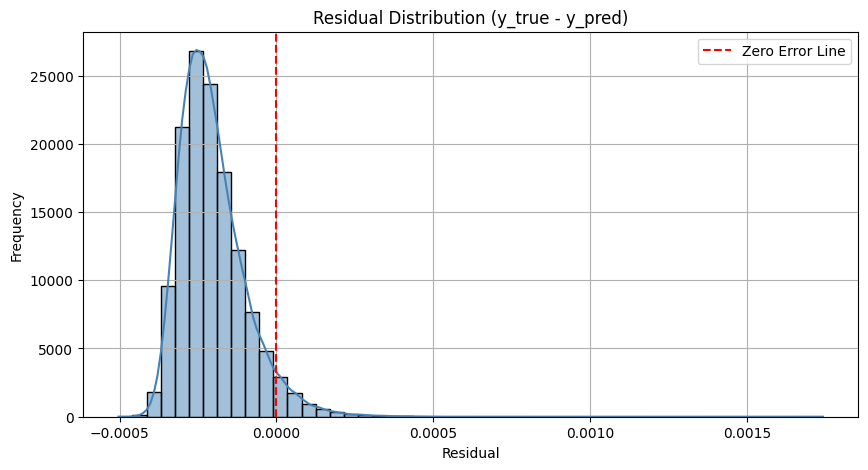

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


residuals = y_true - y_pred

print(f"Mean Residual: {np.mean(residuals):.6f}")
print(f"Std of Residual: {np.std(residuals):.6f}")
print(f"Min Residual: {np.min(residuals):.6f}")
print(f"Max Residual: {np.max(residuals):.6f}")

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=50, color='steelblue')
plt.title("Residual Distribution (y_true - y_pred)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--', label='Zero Error Line')
plt.legend()
plt.grid(True)
plt.show()


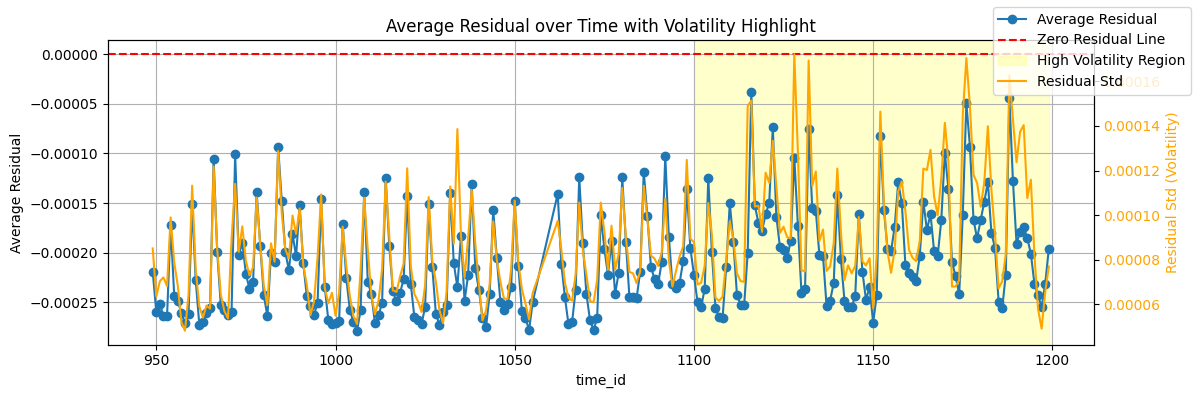

In [52]:
residuals = y_true - y_pred

res_df = pd.DataFrame({
    "time_id": subset["time_id"].values,
    "residual": residuals
})

import matplotlib.pyplot as plt

# depend time_id to compute mean and std（
res_stats = res_df.groupby("time_id")["residual"].agg(['mean', 'std']).reset_index()

# set  time id 
highlight_start = 1100

fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.plot(res_stats["time_id"], res_stats["mean"], marker='o', linestyle='-', label='Average Residual')
ax1.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
ax1.set_xlabel("time_id")
ax1.set_ylabel("Average Residual")
ax1.set_title("Average Residual over Time with Volatility Highlight")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(res_stats["time_id"], res_stats["std"], color='orange', linestyle='-', linewidth=1.5, label='Residual Std')
ax2.set_ylabel("Residual Std (Volatility)", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

#  time_id >= highlight_start
ax1.axvspan(highlight_start, res_stats["time_id"].max(), color='yellow', alpha=0.2, label='High Volatility Region')

fig.legend(loc='upper right')
plt.tight_layout()
plt.show()


## Observation:

In the "Average Residual over Time" plot, we observe that residuals remain relatively stable for time_id < 1100, but show significantly increased volatility afterward.

The model’s predictive performance deteriorates in later time periods.
This could be due to data distribution shifts, such as changes in:
Market conditions (e.g. volatility spikes, news, external shocks);
Underlying feature behavior (e.g. WAP or imbalance instability);

# Time

In [53]:
end_time_4 = time.time()

print(f"Model and Feature Loading Phase time: {end_time_1 - start_time_1:.2f} seconds")
print(f"Feature Engineering: {end_time_2 - start_time_2:.2f} seconds")
print(f"model run time: {end_time_3 - start_time_3:.2f} seconds")
print(f"Total computation time: {end_time_4 - start_time_4:.2f} seconds")

Model and Feature Loading Phase time: 7.04 seconds
Feature Engineering: 112.97 seconds
model run time: 281.14 seconds
Total computation time: 403.22 seconds
